<a href="https://colab.research.google.com/github/Dominic-byte/Team-13-Regression-Predict/blob/master/Sendy_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team 13 Sendy Logistics Challenge

## Contents (finish sections 1, 3, 4, 5, 6, 7, 8, 9)

1. Introduction
2. Imports
3. Definitions
4. Data cleaning and preprocessing
5. Exploratoory data analysis
6. Feature engineering and selection
7. Model building
8. Results interpretation
9. Conclusion

## 1. Introduction

**Problem Landscape*

**About Sendy:** Sendy is a platform established to enable businesses to transport goods efficently across East Africa. Sendy focuses on on building practical solutions for Africa's transportation needs, from developing apps and web solutions, to providing dedicated support for goods on the move.

**Problem** Sendy would like to be able to predict the estimated time of delivery of orders from the point of driver pickup to the point of arrival at final destination.

**Value** This will help Sendy improve customer experience by enhancing customer communication and improving service reliability. In addition, the solution will enable the realisation of cost savings through improved resource management.

**Problem Statement**: **Build** a model to predict the estimated time of delivery of orders from the **`point of driver pickup`** to the **`point of arrival at final destination`**.

## 2. Imports

Packages

In [0]:
%%capture
# Standard Imports
import numpy as np
import pandas as pd

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Notebook Settings
%matplotlib inline
pd.options.display.max_columns = 60
sns.set_style("whitegrid")

Data

In [2]:
# URL to training and testing data
trurl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/Train.csv'
turl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/Test.csv'
rurl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/Riders.csv'
vurl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/VariableDefinitions.csv'

# Loading datasets
train_df = pd.read_csv(trurl, index_col=0)
test_df = pd.read_csv(turl, index_col=0)
riders_df = pd.read_csv(rurl, index_col=0)
variables = pd.read_csv(vurl, index_col=0)

# Storing variable names and test index
columns = train_df.columns
test_index = test_df.index
target = columns[-1]

# Inspect data
print(train_df.shape, test_df.shape, riders_df.shape)
train_df.head(3)
print(target)

(21201, 28) (7068, 24) (960, 4)
Time from Pickup to Arrival


## 3. Definitions

In [3]:
pd.options.display.max_colwidth = 0
variables

,Unique number identifying the order
Order No,
User Id,Unique number identifying the customer on a platform
Vehicle Type,"For this competition limited to bikes, however in practice Sendy service extends to trucks and vans"
Platform Type,"Platform used to place the order, there are 4 types"
Personal or Business,Customer type
Placement - Day of Month,Placement - Day of Month i.e 1-31
Placement - Weekday (Mo = 1),Placement - Weekday (Monday = 1)
Placement - Time,Placement - Time - Time of day the order was placed
Confirmation - Day of Month,Confirmation - Day of Month i.e 1-31
Confirmation - Weekday (Mo = 1),Confirmation - Weekday (Monday = 1)


In [0]:
pd.options.display.max_colwidth = 50

## 4. Data cleaning and preprocessing (BBP)

In [5]:
pd.merge(train_df, riders_df, how='left', on='Rider Id').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 32 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   User Id                                    21201 non-null  object 
 1   Vehicle Type                               21201 non-null  object 
 2   Platform Type                              21201 non-null  int64  
 3   Personal or Business                       21201 non-null  object 
 4   Placement - Day of Month                   21201 non-null  int64  
 5   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 6   Placement - Time                           21201 non-null  object 
 7   Confirmation - Day of Month                21201 non-null  int64  
 8   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 9   Confirmation - Time                        21201 non-null  object 
 10  Arrival at Pickup - Da

### Data types
#### **Numerical**
- Ratio
  - *Number of Orders*
  - *Age*
  - *Number of Ratings*
  - *Time from pickup to arrival* - Target
  - *Geospatial Distance*`
- Interval
  - *Time (Placement, Confimation, Arrival, etc)* 
  - *Distance (KM)*
  - *Temperature*
  - *Precipitation*
  - *Co-ordinates*

#### **Categorical**
- Nominal
  - *User Id*
    - This is categorical as it only varies in the user that has\
      placed the order.
    - It may be possible to determine the frequency of orders\
      placed by customers and determine their loyalty. This may\
      reflect a drivers motivation to provide higher quality\
      service to that user.
  - *Vehicle Type*
    - The type of vehicle used would ordinarily have an impact on\
      delivery time as a motorcycle would be faster than a truck.
    - Since there is only one vehicle type to consider (bike)\
      there is no value to be gained from this data
  - *Platform Type*
    - The source of order placement is qualitative and may give\
      information about the level of service delivery for the\
      various platforms. More frequently used platforms may be\
      serviced better by drivers as they may provide a steady\
      stream of customers.
    - The platform can only take on the values from 1 to 4 and\
      should be stored as an `int16`
  - *Personal or Business*
    - Business orders are likely to be frequent and and located\
      near central business district, whereas personal orders\
      may require further travel to suburban areas. This could\
      have an effect on the travel time.
  - *Day of month (Placement, Confimation, Arrival, etc)*
    - The day of month can only vary in its quality. There may\
      more or less orders placed on a given day of the month.\
    - Since the values of day of month can take on values between\
      1 and 31 it would be most effecient to store it as an `int16`\
      instead of `int64` which is for larger numbers.
    - It may be that more orders are placed on certain days that\
      would result in longer delivery times.    
  - *Weekday*
    - Businesses typically operate on weekdays. It would logically\
      follow that weekdays are busier than weekends resulting in\
      longer delivery times due  to traffic or the volume of\
      orders.
    - Since the weekday is represented by 1 to 7, it should be\
      stored as an `int16`
    - *Rider Id*

- Ordinal
  - *Average rating*
    - Drivers are usually rated on a scale from one to 5. As a driver\
      recieves more ratings, the will begin to settle around their\
      true score. This score could reflect the driver's performance\
      with respect to timeliness.

### Cleaning functions

In [0]:
def data_preprocessing(df, na_thresh = 0, strategy = 'mean'):
  """Function that preprocesses data used for predictions and testing
  Parameters
  ----------
  df: DataFrame
          DataFrame to preprocess.
  na_thresh: float
          float between 0.0 and 1.0 specifying the drop/fillna
          threshhold
  strategy: string
          Filling strategy, 'mean', 'median' or  'rolling'
  Returns
  -------
  df: DataFrame
          Preprocessed DataFrame

  """
  cdf = df.copy()
  old = cdf.memory_usage().sum()
  # Create lists of columns to change
  integers = [col for col in cdf.columns if cdf[col].dtypes == 'int64']
  floats = [col for col in cdf.columns if cdf[col].dtypes == 'float64']
  time_cols = [col for col in cdf.columns if col.endswith("Time")]

  # Reduce size of data storage types
  cdf[integers] = cdf[integers].astype('int16')
  cdf[floats] = cdf[floats].astype('float16')
  for col in time_cols:
    cdf[col] = pd.to_datetime(cdf[col]).dt.time
  
  # Correcting specific columns
  if 'Distance (KM)' in cdf.columns:
    cdf['Distance (KM)'] = cdf['Distance (KM)'].astype('float16') 

  new = cdf.memory_usage().sum()
  print("Bytes\t","\nOld:\t", str(old), "\nNew:\t", "("+str(new)+")", "\nSaved:\t", str(old - new))
  return cdf

In [8]:
%%capture [bytes saved]
# Store transformations in EDA DataFrame
eda_df, test_clean, riders_clean = data_preprocessing(train_df, na_thresh = 0, strategy = 'mean'), data_preprocessing(test_df, na_thresh = 0, strategy = 'mean'), data_preprocessing(riders_df, na_thresh = 0, strategy = 'mean')

UsageError: unrecognized arguments: saved]


## 5. Data Exploration and preparation

a. Exploratory data analysis


1. Target - Time from Pickup to Arrival

In [0]:
# Setting variable for Target
columns = train_df.columns
target = columns[-1]

# Confirming the caluclation of the Target

Target = pd.to_datetime(train_df['Arrival at Destination - Time']) - pd.to_datetime(train_df['Pickup - Time'])
list(Target.dt.seconds[:]) == list(train_df[target][:])

True

In [0]:
eda_df[target].describe()

count    21201.000000
mean      1556.920947
std        987.270788
min          1.000000
25%        882.000000
50%       1369.000000
75%       2040.000000
max       7883.000000
Name: Time from Pickup to Arrival, dtype: float64

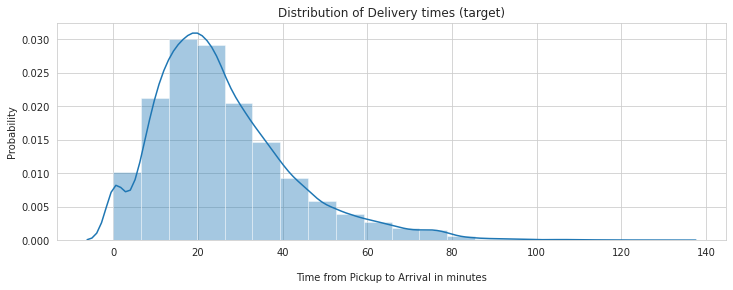

In [0]:
# Histogram
fig = plt.figure(figsize=(12,4))
sns.distplot(eda_df[target]/60, bins =20)
plt.title('Distribution of Delivery times (target)')
plt.xlabel('\n'+target+' in minutes')
plt.ylabel("Probability")
plt.show()

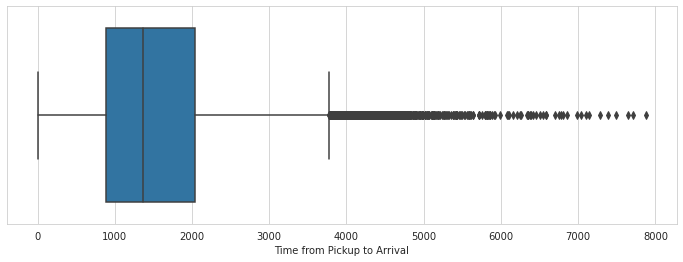

In [0]:
# Outliers
fig = plt.figure(figsize=(12,4))
sns.boxplot(x=target,data=eda_df)

quick notes
 - majority of trips are arund 2000 seconds

2. Univariate analysis (D)

In [0]:
2.1 Numerical

In [0]:
#Analysing the features based on one variable type
col_numerical = [col for col in eda_df.columns if eda_df[col].dtypes != 'object' and col !='Time from Pickup to Arrival']
eda_df[col_numerical].describe()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long
count,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,2.120100e+04,1.683500e+04,552.000000,21201.000000,2.120100e+04,21201.000000,2.120100e+04
mean,2.752182,15.653696,3.240083,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,inf,inf,7.906250,-1.281250,inf,-1.282227,inf
std,0.625178,8.798916,1.567295,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,5.671875e+00,3.617188e+00,17.093750,0.030548,3.918457e-02,0.034851,4.562378e-02
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.120312e+01,0.099976,-1.438477,3.665625e+01,-1.430664,3.659375e+01
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000e+00,2.059375e+01,1.074219,-1.300781,3.678125e+01,-1.300781,3.678125e+01
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000e+00,2.350000e+01,2.900391,-1.279297,3.681250e+01,-1.284180,3.681250e+01
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,1.300000e+01,2.600000e+01,4.898438,-1.256836,3.684375e+01,-1.260742,3.684375e+01
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,4.900000e+01,3.209375e+01,99.125000,-1.147461,3.700000e+01,-1.030273,3.703125e+01


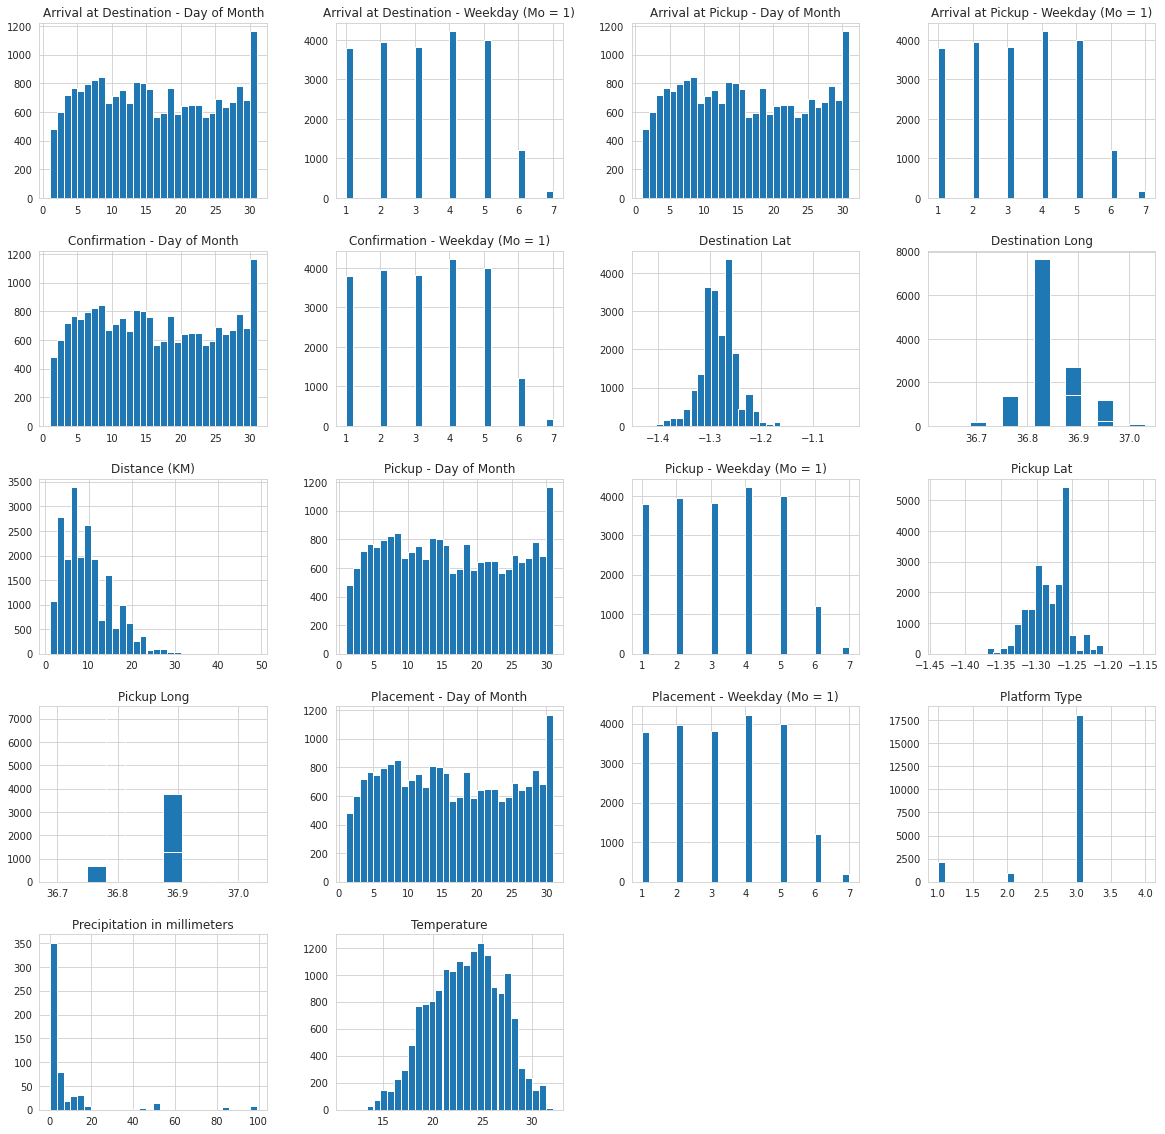

In [0]:
#Plot histogram of numerical values
def histogram_plot(df,numerical_cols,bins):
  """Function creates histogram of all numerical columns
  Parameters
  ----------
  df: DataFrame
          DataFrame to preprocess.
  numerical_cols: list
          list of numerical columns
  bins: string
          number of bins you want histogram to create
  Returns
  -------
  {Plot}: Returns plot of column histograms for analysis
          
  """
  df[col_numerical].hist(bins = bins, figsize  = (20,20))
  return plt.show()
histogram_plot(eda_df,col_numerical,30)

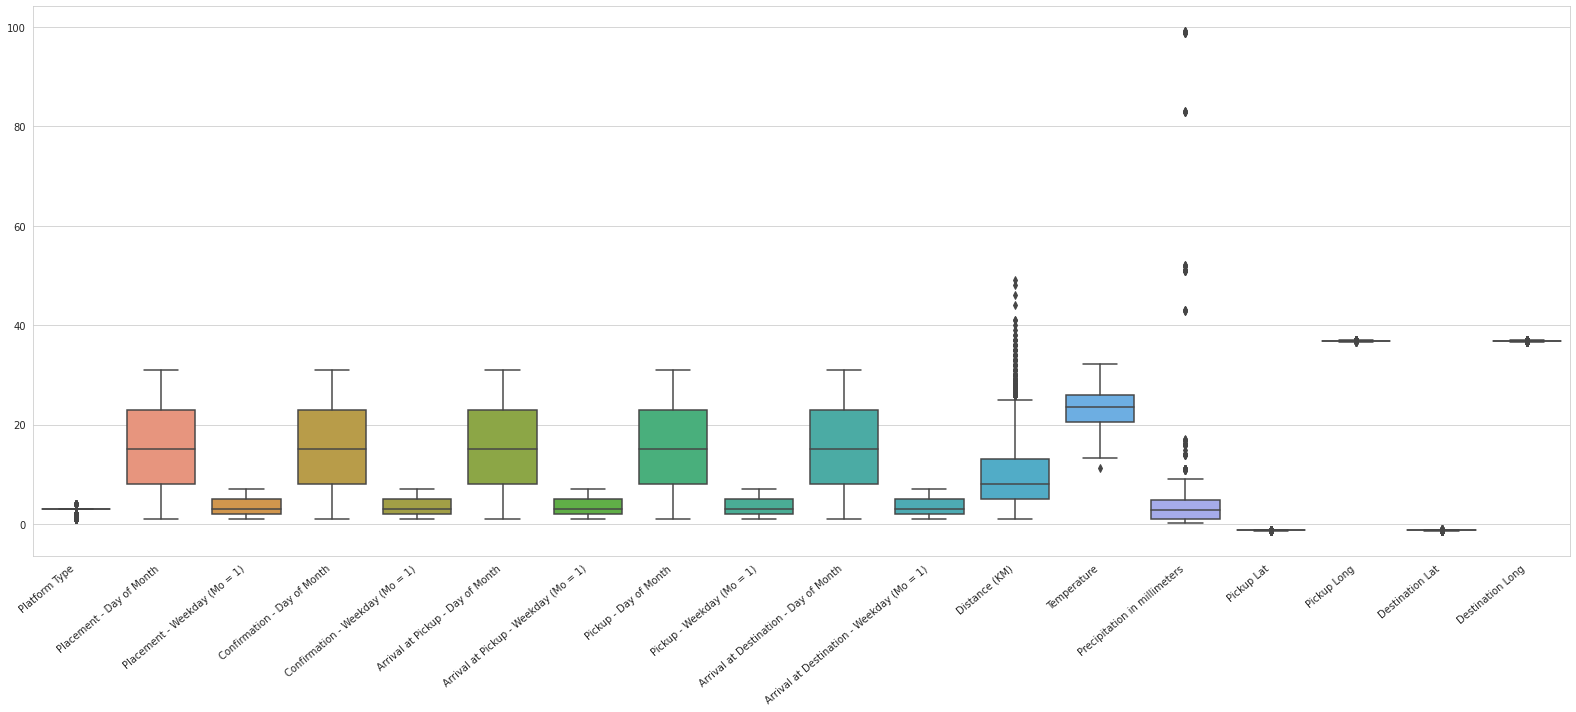

In [0]:
#Plot Boxplot of graphs
plt.figure(figsize=(22,10))
ax = sns.boxplot(data = eda_df[col_numerical])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

3. Bivariate analysis (AB)

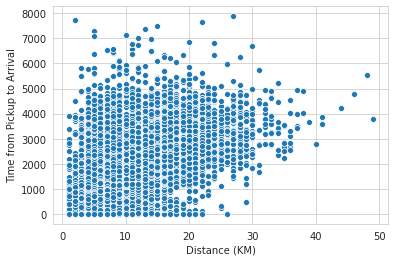

In [0]:
sns.scatterplot(x=eda_df['Distance (KM)'],y=eda_df[target])

5. Remove Collinearity (HELPER FUNCTIONS)
6. Missing values treatment (HELPER FUNCTIONS)


In [0]:
def null(df, na_thresh, strategy = "median"):
  """Function that drops columns with more than na_thresh null from
  
  """
  # Dropping NaN's
  for col in no_null.columns:
    missing = no_null[col].isnull().sum()/len(ddf)
    if missing > na_thresh:
      no_null.drop(columns=col, inplace=True)
    
  # Filling NaN's
  for col in no_null.columns:
    if no_null[col].isnull().sum() > 0:
      if no_null[col].dtypes == 'object':
        no_null[col].fillna(no_null[col].mode(), inplace=True) 
      elif strategy == 'mean':
        no_null[col].fillna(round(no_null[col].mean()), inplace=True)
      elif strategy == 'median':
        no_null[col].fillna(round(no_null[col].median()), inplace=True)
      elif strategy == 'rolling':
        no_null[col].fillna(no_null[col].rolling(7).mean(), inplace=True)
      else:
        raise ValueError
  return no_null

7. Outlier treatment (HELPER FUNCTIONS)

In [0]:
def scaler(df, strategy='standardize'):
  """Function that scales numerical columns
  Parameters
  ----------
  df: DataFrame
          DataFrame to preprocess.
  strategy: string
          scaling strategy, 'nomalisze', 'standardize'
  Returns
  -------
  df: DataFrame
          Preprocessed DataFrame with numwrical columns
          standardized
  """ 

IndentationError: ignored

In [0]:
out_null(df, na_thresh, strategy = "median")

b. Feature engineering and selection (B)


1. Variable transformation

In [0]:
# create working dataframe
# def var_transform(df):
trans_df = 

2. Variable creation

### 6. Model building

## 6. Results interpretation

## 7. Conclusion